In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor

## Nominal Values

In [4]:
model_LSM = LinearRegression().fit(df[['LotArea']].values, df[['SalePrice']].values);
model_huber = HuberRegressor().fit(df[['LotArea']].values, df[['SalePrice']].values);

c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
predicts_LSM = model_LSM.predict(df[['LotArea']].values)
predicts_huber = model_huber.predict(df[['LotArea']].values)

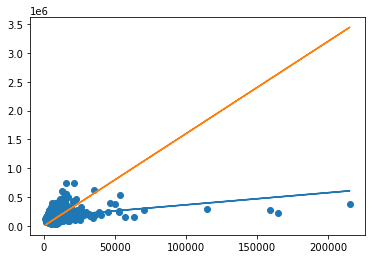

In [6]:
import matplotlib.pyplot as plt

plt.scatter(df[['LotArea']].values, df[['SalePrice']].values)
plt.plot(df[['LotArea']].values, predicts_LSM)
plt.plot(df[['LotArea']].values, predicts_huber)

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.optimize import  minimize
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.patches as mpatches
from itertools import repeat


def mapU(pair_x_c):
    #print(pair_x_c)
    x_diff = pair_x_c[0]
    c = pair_x_c[1]
    return ( 1 - (1- (x_diff / c)**2 )**3 ) if np.abs(x_diff) < c else 1


def Tukey(u, c):
    pairs = list(zip(u,  repeat(c)))
    return np.sum(list(map(mapU, pairs)))



#Требуемая функция
def F(X, Y_true, weights = None, fit_c = True):
    X = X.reshape(len(X), -1)
    C = 1e5
    if weights is None:
            C = 1e5
            X0 = np.random.normal(0, 10, size = X.shape[1] + 2)
            X0[-1] = C
    else:
            Y_pred = weights[0]+np.sum(X * weights[1:], axis = 1)
            C = mean_absolute_error(Y_true, Y_pred)
            X0 = np.array(weights + [C]) 


    def Fit(coefs): 
        if not fit_c:
            coefs[-1] =  C
        Y_pred = np.sum(coefs[0]+X * coefs[1:-1], axis = 1) # y = b + x*a
        diff = (Y_true.reshape(-1, 1) - Y_pred.reshape(-1, 1)).tolist()
        return Tukey(diff, c = coefs[-1])
    
    #Зададим исходные веса, чтобы не попасть
    #в локальный минимум, используя midhinge для порога C
    
    #Минимизируем Tukey
    res = minimize(Fit, X0, method='L-BFGS-B') 
    return res 

In [8]:
init_tukey_weights = [model_LSM.intercept_[0]] + [model_LSM.coef_[0][0]]
init_tukey_weights

[158836.15189687657, 2.0999719517076754]

In [9]:
X = df[['LotArea']].values
Y = df[['SalePrice']].values
#X = X.reshape(len(X), -1)
Y = Y.reshape(len(Y), -1)
coefs = F(X = X
    , Y_true = Y
    , weights= init_tukey_weights #LSM Weights
    , fit_c= True
    #, weights= model_huber.coef_.tolist() #Huber Weights
    )
coefs.x

c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([1.60019626e+05, 2.03239092e+00, 3.27629460e+06])

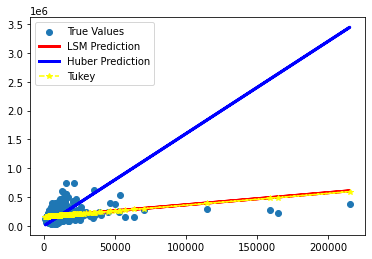

In [10]:
import matplotlib.pyplot as plt

plt.scatter(df[['LotArea']].values, df[['SalePrice']].values, label = 'True Values')
plt.plot(df[['LotArea']].values, predicts_LSM, label = 'LSM Prediction', color = 'red', linewidth = 3)
plt.plot(df[['LotArea']].values, predicts_huber, label = 'Huber Prediction', color = 'blue', linewidth = 3)
plt.plot(df[['LotArea']].values, coefs.x[0] + np.sum(df[['LotArea']].values * coefs.x[1:-1], axis = 1), '--*', label = 'Tukey', color = 'yellow')
plt.legend()

## PolyNominal Searching

In [11]:
from  copy import deepcopy as deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
results = {}
for p in np.arange(2, 15):
    try:
        #X = df[['LotArea', 'Bias']].values
        df['NormLotArea'] = (df['LotArea'] - df['LotArea'].mean()) / df['LotArea'].std()
        X = df[['NormLotArea']].values
        #X = df[['LotArea']].values
        X = X.reshape(len(X), -1)

        X = PolynomialFeatures(degree = p, include_bias=False).fit_transform(X)#[:, -1]
        X = X.reshape(len(X), -1)
        X_train, X_test, Y_train, Y_test = train_test_split(X, df[['SalePrice']].values, random_state=42)
        model_LSM = LinearRegression().fit(X_train, Y_train);
        model_huber = HuberRegressor().fit(X_train, Y_train);

        init_tukey_weights = model_LSM.intercept_.tolist() + np.squeeze(model_LSM.coef_).tolist()

        coefs = F(X = X_train
            , Y_true = np.squeeze(Y_train)
            , weights= init_tukey_weights #LSM Weights
            , fit_c= True
            #, weights= model_huber.coef_.tolist() #Huber Weights
            )
        
        predicts_LSM = model_LSM.predict(X_test)
        predicts_huber = model_huber.predict(X_test)
        
        res_p={}
        res_p['LSM R2']= r2_score(Y_test, predicts_LSM)
        res_p['Huber R2'] = r2_score(Y_test, predicts_huber)
        res_p['Tukey R2'] = r2_score(Y_test,  coefs.x[0] + np.sum(X_test * coefs.x[1:-1], axis = 1))

        res_p['Weights LSM'] = deepcopy(model_LSM)
        res_p['Weights Huber'] = deepcopy(model_huber)
        res_p['Model Tukey'] = deepcopy(coefs)

        results[p]= res_p
    except:
        continue    

c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kirill\.conda\envs\bayes\lib\site-pa

In [12]:
for r in results:
    print(f'Polynome {r} : ',results[r]['LSM R2'], results[r]['Huber R2'], results[r]['Tukey R2'])

Polynome 2 :  0.11802142521110304 0.10378318766106309 -1.1506584864596308
Polynome 3 :  0.13988827943987325 0.11778037186170665 -5.048891141908989
Polynome 4 :  0.1485453194896066 0.12535517219516512 0.14854591611233492
Polynome 7 :  0.15506000149805832 -4.550727061863037 0.15506000149805832
Polynome 8 :  0.16894855883087834 -4.5507383086018915 0.16894855883087834
Polynome 9 :  0.10937583430654163 -4.550741599534047 0.10937583430654696
Polynome 10 :  0.07543972649251529 -4.550742565782403 0.07543972649252295
Polynome 11 :  0.06567173936430448 -4.550742849863243 0.06567173936457715
Polynome 12 :  -0.12127471031996495 -4.550742933418479 -0.12127471032063797


In [13]:
best_LSM_p = sorted(results.items(), key = lambda x: -x[1]['LSM R2'])[0]
best_Huber_p = sorted(results.items(), key = lambda x: -x[1]['Huber R2'])[0]
best_Tukey_p = sorted(results.items(), key = lambda x: -x[1]['Tukey R2'])[0]

### Best LSM

C:\Users\Kirill\AppData\Local\Temp\ipykernel_12232\3602148065.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  XY = np.array(sorted(list(zip(df['LotArea'].values, predicts_LSM)), key = lambda x: x[0]))


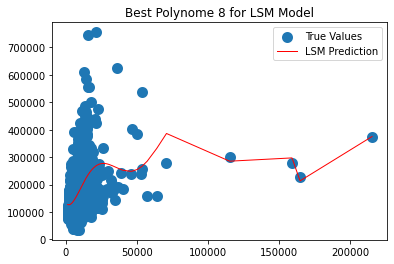

In [14]:
p = best_LSM_p[0]
X = df[['NormLotArea']].values
#X = df[['LotArea']].values
X = X.reshape(len(X), -1)

X = PolynomialFeatures(degree = p, include_bias=False).fit_transform(X)#[:, -1]
X = X.reshape(len(X), -1)

model_LSM = best_LSM_p[1]['Weights LSM']
predicts_LSM = model_LSM.predict(X)

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['LotArea'].values, df[['SalePrice']].values, label = 'True Values', linewidths=5)

XY = np.array(sorted(list(zip(df['LotArea'].values, predicts_LSM)), key = lambda x: x[0]))
plt.plot(XY.T[0] , XY.T[1], label = 'LSM Prediction', color = 'red', linewidth = 1)
plt.title(f'Best Polynome {p} for LSM Model')
plt.legend()
plt.show()

### Best Huber

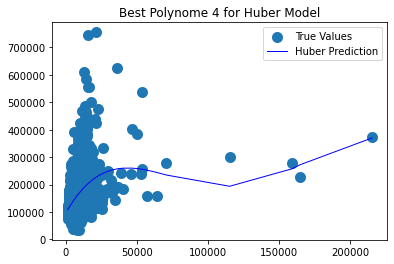

In [15]:
p = best_Huber_p[0]
X = df[['NormLotArea']].values
#X = df[['LotArea']].values
X = X.reshape(len(X), -1)

X = PolynomialFeatures(degree = p, include_bias=False).fit_transform(X)#[:, -1]
X = X.reshape(len(X), -1)

model_huber = best_Huber_p[1]['Weights Huber']
predicts_huber = model_huber.predict(X)


import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['LotArea'].values, df[['SalePrice']].values, label = 'True Values', linewidths=5)

XY = np.array(sorted(list(zip(df['LotArea'].values, predicts_huber)), key = lambda x: x[0]))
plt.plot(XY.T[0] , XY.T[1], label = 'Huber Prediction', color = 'blue', linewidth = 1)


plt.title(f'Best Polynome {p} for Huber Model')
plt.legend()
plt.show()

### Best Tukey

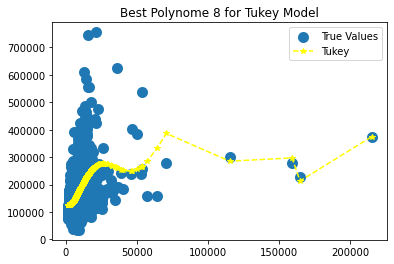

In [16]:
p = best_Tukey_p[0]
X = df[['NormLotArea']].values
#X = df[['LotArea']].values
X = X.reshape(len(X), -1)

X = PolynomialFeatures(degree = p, include_bias=False).fit_transform(X)#[:, -1]
X = X.reshape(len(X), -1)

coefs = best_Tukey_p[1]['Model Tukey']

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['LotArea'].values, df[['SalePrice']].values, label = 'True Values', linewidths=5)


XY = np.array(  
                sorted(list(zip(df['LotArea'].values.tolist()
                            ,  coefs.x[0]+np.sum(X * coefs.x[1:-1], axis = 1)))
                    , key = lambda x: x[0])
                    )
plt.plot(XY.T[0] , XY.T[1], '--*', label = 'Tukey', color = 'yellow')
plt.title(f'Best Polynome {p} for Tukey Model')
plt.legend()
plt.show()

### Best for each Model Together

C:\Users\Kirill\AppData\Local\Temp\ipykernel_12232\99190932.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  XY = np.array(sorted(list(zip(df['LotArea'].values, predicts_LSM)), key = lambda x: x[0]))


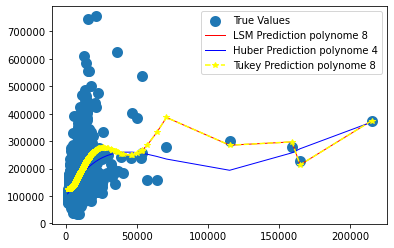

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['LotArea'].values, df[['SalePrice']].values, label = 'True Values', linewidths=5)

XY = np.array(sorted(list(zip(df['LotArea'].values, predicts_LSM)), key = lambda x: x[0]))
plt.plot(XY.T[0] , XY.T[1], label = f'LSM Prediction polynome {best_LSM_p[0]}', color = 'red', linewidth = 1)

XY = np.array(sorted(list(zip(df['LotArea'].values, predicts_huber)), key = lambda x: x[0]))
plt.plot(XY.T[0] , XY.T[1], label = f'Huber Prediction polynome {best_Huber_p[0]}', color = 'blue', linewidth = 1)

XY = np.array(  
                sorted(list(zip(df['LotArea'].values.tolist()
                            ,  coefs.x[0]+np.sum(X * coefs.x[1:-1], axis = 1)))
                    , key = lambda x: x[0])
                    )
plt.plot(XY.T[0] , XY.T[1], '--*', label = f'Tukey Prediction polynome {best_Tukey_p[0]}', color = 'yellow')
plt.legend()